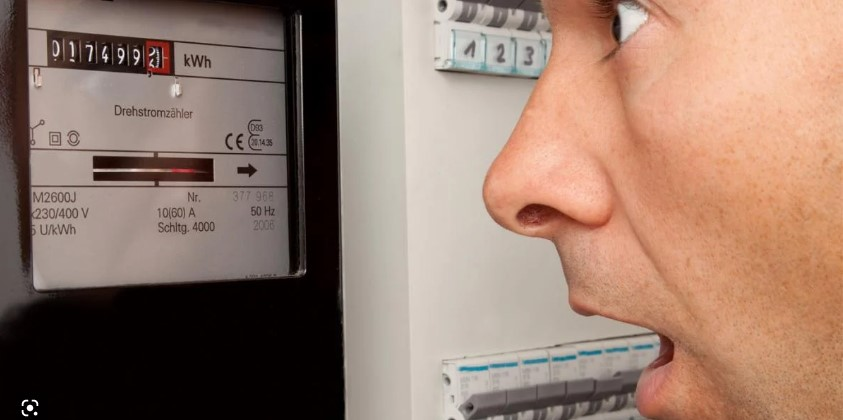

# Project 1 - Group 5
---
### This Project created a tool that analyzes personal energy usage data in relationship to local temperature and tries to predict the future cost of energy for that household taking into account hypothetical temperature changes per season and changes in kWh price based on the best correlation between kWh and natural gas or crude oil. Lastly it utilizes Monte Carlo simulation to predict the future price of kWh, to ultimately come to the future cost of energy for that household. 
---
### General steps of the Tool
1. Import of kWh usage data

2. Import via API of local weather data and save as csv file [aerisweather](https://www.aerisweather.com/)
* for more information you can go to their website or github account:
[aerisweather github](https://github.com/aerisweather/python-tools/blob/main/conditions/historical_conditions_date_range_download.ipynb)

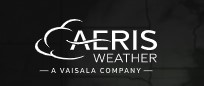

3. Analysis of relationship between household kWh energy usage and temperature sliced into seasons
* The tool explores the relationship of historical kWh energy usage and historical temperatures using linear regression using sklearn library per season.
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

4. Tool predicts future kWh usage for a household based on the regression results of step 3 and manual input for expected temperature changes per season going forward

5. To calculate the future cost of energy (kWh) the tool calculates the correlation between the kWh price and the main two energy commodities in the US. Natural Gas (NG) and Crude Oil (CL)

6. To calculate the future cost of energy (kWh) the tool utilizes Monte Carlo simulation using the product to has the highest correlation with the kWh price

7. Finally the tool will estimate the future cost of energy for a house hold using the following formula:

* **Calculation 1: future kWh usage** 
* slope x hypothetical temperature + intercept
* **Calculation 2 future cost of kWh:**
* future kWh usage x (MC simulation output x correlation factor x current price of kWh) + ((1 - correlation factor) x current price of kWh)
* **Calculation 3 sum of future energy cost**
* sum all cost of kWh


In [100]:
# Import required libraries
from datetime import datetime as dt
import os
from pathlib import Path
import pandas as pd
from pandas import DatetimeIndex
import hvplot.pandas
import sqlalchemy
from sqlalchemy import inspect
from sklearn.linear_model import LinearRegression
from MCForecastTools import MCSimulation
import numpy as np
import holoviews as hv

# Warning filtration
import warnings
warnings.filterwarnings("ignore")

In [55]:
# Select date frame you would like to take into account for analysis
first_date = '2022-01-01'
last_date = '2022-12-31'

### Finished

In [56]:
# Input expected changes in temperature

#hypo_temp_winter = hypo_temp("winter")
#hypo_temp_spring = hypo_temp("spring")
#hypo_temp_summer = hypo_temp("summer")
#hypo_temp_fall = hypo_temp("fall")


### Finished

In [57]:
# ONLY FOR PRESENTATION PURPOSES!!!! Changed to be able to present in Voila
hypo_temp_winter = -10 #hypo_temp("winter")
hypo_temp_spring = +5 #hypo_temp("spring")
hypo_temp_summer = +10 #hypo_temp("summer")
hypo_temp_fall = -6 #hypo_temp("fall")

### Finished

In [58]:
# Define function to request input from user and change input to a float

def hypo_temp(season):
    hypo_temp = input(f'Please provide an estimate on how temperature will change next year for the {season}?')
    hypo_temp = float(hypo_temp)
    return(hypo_temp)


In [59]:
def season_print():
    print(f'Change for winter season: {hypo_temp_winter} Fahrenheit\nChange for spring season: {hypo_temp_spring} Fahrenheit\nChange for summer season: {hypo_temp_summer} Fahrenheit\nChange for fall season: {hypo_temp_fall} Fahrenheit')

In [60]:
print(f'For this presentation we used the following temperature changes to calculate the future energy usage and cost of a household:')
season_print()

For this presentation we used the following temperature changes to calculate the future energy usage and cost of a household:
Change for winter season: -10 Fahrenheit
Change for spring season: 5 Fahrenheit
Change for summer season: 10 Fahrenheit
Change for fall season: -6 Fahrenheit


In [61]:
# Import Weather Data get csv weather data and format 
weather_df = pd.read_csv(Path(
    '../Niels/Resources/weather_newyorkny_download_2021_2022_per_hr.csv')
)

### Finished

In [62]:
# CLEAN WEATHER DATA 

try:
    #strip left 10 characters from weather data periods.dateTimeISO date to create date column
    weather_df['date'] = weather_df['periods.dateTimeISO'].str[:10]
    
    weather_df['hour_Weather'] = weather_df['periods.dateTimeISO'].str[11:19]
    
    weather_df['Start Date'] = weather_df['date'] + ' ' + weather_df['hour_Weather']
    
    weather_df['Start Date'] = pd.to_datetime(weather_df['Start Date'])
    
    # change date format to date with actual date from string for easier plotting and use of date column
    weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

    # set date as index in weather data
    weather_df = weather_df.set_index('date')

    # remove unnamed column
    weather_df.drop(columns=["Unnamed: 0"],inplace=True)
    weather_df.drop(columns=["periods.dateTimeISO"],inplace=True) 

except:
    pass
    print('You ran this part already, no worries check if below dataframe is correctly configured')


# Display Weather Data
#weather_df.head()

### Finished

In [63]:
# Import Energy Usage Data
energy_df = pd.read_csv(Path(
    '../Niels/Resources/Energy_usage_21_22_per_hr.csv')
)

### Finished

In [64]:
# CLEAN ENERGY USAGE DATA 

try:
    
    #strip left 10 characters from weather data periods.dateTimeISO date to create date column
    energy_df['Start Date'] = pd.to_datetime(energy_df['Start Date'])
    
    # Create hour column to line up both files correctly
    energy_df['hour_Energy'] = energy_df['Start Date'].dt.time
    
    #create new column date seperating start date column into date and time
    energy_df['date'] = pd.to_datetime(energy_df['Start Date']).dt.date
    
    # set date as index in weather data
    energy_df = energy_df.set_index('date')
    
    # Remove orignial start date from data frame (not necessary)
    #energy_df.drop(columns=['Start Date'], inplace=True)

except:
    pass
    print('You already ran this part already, no worries check if below dataframe is correctly configured')


# Display Weather Data
#energy_df.head()


### Finished

In [65]:
# Merge both Energy and Weather dataframe

# select timeframes to analyze
start_date = pd.to_datetime(first_date).date()
end_date = pd.to_datetime(last_date).date()

#select only data within set time frame from weather df
weather_df_select = weather_df.loc[start_date:end_date]

#select only data within set time frame from Energy df
energy_df_select = energy_df.loc[start_date:end_date]

# merge weather data with the energy usage data
merged_data = pd.merge(weather_df_select,energy_df_select, how = 'inner', on = ['Start Date'])

merged_data['date'] = pd.to_datetime(merged_data['Start Date']).dt.date

merged_data= merged_data.set_index('Start Date')


# Add columns day, month, year and month_date to be able to make interactive graphs later (month_date is used to determine which season it is in next step)
merged_data['hour'] = pd.DatetimeIndex(merged_data.index).hour 
merged_data['day'] = pd.DatetimeIndex(merged_data.index).day
merged_data['month'] = pd.DatetimeIndex(merged_data.index).month
merged_data['year'] = pd.DatetimeIndex(merged_data.index).year
merged_data['month_date'] = pd.DatetimeIndex(merged_data.index).strftime('%m%d')
merged_data['month_date'] = merged_data['month_date'].astype(float)

# create a column that displays the season (winter, spring, fall or summer)
merged_data['season'] = np.where((merged_data['month_date'] >= 1221),"winter",
                                np.where((merged_data['month_date'] >=101) & (merged_data['month_date'] <321), "winter",
                                         np.where((merged_data['month_date'] >=321) & (merged_data['month_date'] <621), "spring",
                                                  np.where((merged_data['month_date'] >=621) & (merged_data['month_date'] <921), "summer","fall"))))

### Finished

In [66]:
# include temperature increase
merged_data['hypo_temp'] = np.where((merged_data['season']=='winter'), merged_data['periods.tempF'] + hypo_temp_winter,
                                     np.where((merged_data['season']=='spring'), merged_data['periods.tempF'] + hypo_temp_spring,
                                              np.where((merged_data['season']=='summer'), merged_data['periods.tempF'] + hypo_temp_summer,
                                                       merged_data['periods.tempF'] + hypo_temp_fall)))

try:
    merged_data.drop(columns=["Meter"],inplace=True)
    merged_data.drop(columns=["periods.feelslikeF"],inplace=True) 
    merged_data.drop(columns=["periods.humidity"],inplace=True) 
except:
    pass


### Below shows combined kWh usage data and temperature data provide by Aeris API for new york. Also there is a hypo_temp column that can take into account temperature changes. Highlighted above are the temperature changes per season that were taking into account in this presentation of our results. 

In [67]:
# Display Data
merged_data.head()

### Finished

,place.name,place.country,periods.tempF,hour_Weather,kWh,hour_Energy,date,hour,day,month,year,month_date,season,hypo_temp
Start Date,,,,,,,,,,,,,,
2022-01-01 00:00:00,new york,us,52.16,00:00:00,1.98,00:00:00,2022-01-01,0,1,1,2022,101.0,winter,42.16
2022-01-01 01:00:00,new york,us,52.16,01:00:00,1.72,01:00:00,2022-01-01,1,1,1,2022,101.0,winter,42.16
2022-01-01 02:00:00,new york,us,52.52,02:00:00,3.19,02:00:00,2022-01-01,2,1,1,2022,101.0,winter,42.52
2022-01-01 03:00:00,new york,us,52.16,03:00:00,1.71,03:00:00,2022-01-01,3,1,1,2022,101.0,winter,42.16
2022-01-01 04:00:00,new york,us,52.56,04:00:00,1.75,04:00:00,2022-01-01,4,1,1,2022,101.0,winter,42.56


In [68]:
# Create the connection string for your SQLite database
database_connection_string = 'sqlite:///'

# Pass the connection string to the SQLAlchemy create_engine function
engine = sqlalchemy.create_engine(database_connection_string)

# Confirm that the database engine was created.
engine

### Finished

Engine(sqlite:///)

In [69]:
# Using the merged data DataFrame, create a table called weather_kwh_usage inside newly created database
merged_data.to_sql(
    'weather_kwh_usage', 
    engine, 
    index=True, 
    if_exists='replace'
)

# Confirm that the table was created by calling the table_names function
inspect(engine).get_table_names()

### Finished

['weather_kwh_usage']

In [70]:
# define function to run SQl query and create Scatter and regression line

def scatter_season(season_input):
# create query with season input
    query = f"""
    SELECT *
    FROM weather_kwh_usage
    WHERE season = '{season_input}'
    """
# Using the query, read the data from the database into a Pandas DataFrame     
    query_df = pd.read_sql_query(query, con=engine)
    
# Prepare data to perform linear regression for the seasonr
    x = np.array(query_df['periods.tempF']).reshape((-1,1))
    y = np.array(query_df['kWh'])

# Set Regression model parameters
    model = LinearRegression().fit(x,y)

# Print r_sq score, model intercept and slope of regression line
    r_sq = model.score(x,y)
    #print(f"coefficient of determination: {r_sq:.4f}")
    print(f"{season_input} intercept: {model.intercept_:.4f}")
    print(f"{season_input} slope: {model.coef_}")

    # determine slope and intercept of regression line
    y_intercept = model.intercept_
    gradient = model.coef_[0]
    
# Create a regression line and a scatter plotter
    slope = hv.Slope(gradient,y_intercept)
    scatter = hv.Scatter((x, y))

# Create plot with scatter and regression line
    combined_scatter = scatter * slope
    graph = combined_scatter.opts(
    height=500,
    width=800,
    xlabel = 'Temperature',
    ylabel = 'kWh Usage',
    title=f'Usage Scatter with Linear Regression {season_input},\n with slope of {gradient:.2f} and intercept of {y_intercept:.2f}')

# Return the scatter of the function
    return(display(combined_scatter))

### Finished    

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 winter season

In [71]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('winter')

### Finished

winter intercept: 4.8511
winter slope: [-0.04722497]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 Spring season

In [72]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('spring')

### Finished

spring intercept: 1.7915
spring slope: [0.0080941]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 Summer season

In [73]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('summer')

### Finished

summer intercept: 1.1343
summer slope: [0.01970737]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 Fall season

In [74]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('fall')

### Finished

fall intercept: 4.1366
fall slope: [-0.03146721]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

In [75]:
# define function to determine hypothetical usage in case of increase or decrease in temperature depeding on hypo temp input

def hypo_usage_season(season):
# create query with season input
    query_all = f"""
    SELECT * 
    FROM weather_kwh_usage
    """
# Using the query, read the data from the database into a Pandas DataFrame
    all_df = pd.read_sql_query(query_all, con=engine)

# Use only the part of the the dataframe that matches the current input season
    all_df = all_df[(all_df['season']==season)]
    
# Prepare data to perform linear regression for the season
    x = np.array(all_df['periods.tempF']).reshape((-1,1))
    y = np.array(all_df['kWh'])

# Set model parameters
    model = LinearRegression().fit(x,y)

# Display R-square or the season model
    r_sq = model.score(x,y)

# determine slope and intercept of regression line of season
    y_intercept = model.intercept_
    gradient = model.coef_[0]

# Create hypo usage column in dataframe that calculates hypothetical usage based on tempurature change based on current usage regression
    all_df['hypo_usage'] = gradient * all_df['hypo_temp'] + y_intercept

# return updated datafram
    return(all_df)

### Finished

In [76]:
# run all 4 seasons through the hypo_usage_season function and name a variable for the different outputs
winter_df_new_usage = hypo_usage_season('winter')
spring_df_new_usage = hypo_usage_season('spring')
summer_df_new_usage = hypo_usage_season('summer')
fall_df_new_usage = hypo_usage_season('fall')

### Finished

In [77]:
# Concatenate all the data frames into 1 datafram
df_new_usage_winter_spring = pd.concat([winter_df_new_usage,spring_df_new_usage])
df_new_usage_winter_spring_summer = pd.concat([df_new_usage_winter_spring,summer_df_new_usage])
df_new_usage_winter_spring_summer_fall = pd.concat([df_new_usage_winter_spring_summer,fall_df_new_usage])
df_hypo_usage = df_new_usage_winter_spring_summer_fall.sort_values('date')

### Finished

### Below are the results of future kWh usage based on the determined by the different seasonal regression functions and hypothetical temperature changes in column hypo_usage

In [78]:
# Display Data
df_hypo_usage.head()

,Start Date,place.name,place.country,periods.tempF,hour_Weather,kWh,hour_Energy,date,hour,day,month,year,month_date,season,hypo_temp,hypo_usage
0,2022-01-01 00:00:00.000000,new york,us,52.16,00:00:00,1.98,00:00:00.000000,2022-01-01,0,1,1,2022,101.0,winter,42.16,2.860046
23,2022-01-01 23:00:00.000000,new york,us,53.78,23:00:00,2.44,23:00:00.000000,2022-01-01,23,1,1,2022,101.0,winter,43.78,2.783542
22,2022-01-01 22:00:00.000000,new york,us,54.32,22:00:00,4.14,22:00:00.000000,2022-01-01,22,1,1,2022,101.0,winter,44.32,2.758040
21,2022-01-01 21:00:00.000000,new york,us,55.04,21:00:00,2.38,21:00:00.000000,2022-01-01,21,1,1,2022,101.0,winter,45.04,2.724038
20,2022-01-01 20:00:00.000000,new york,us,55.22,20:00:00,2.44,20:00:00.000000,2022-01-01,20,1,1,2022,101.0,winter,45.22,2.715538


In [79]:
# Save CSV file to Resources folder under Group5Project1\Niels\Resources
# Set the path and name were to save csv file
csv_output_path = Path('../Niels/Resources/df_hypo_usage_per_hr.csv')

# Save dataframe to folder
df_hypo_usage.to_csv(csv_output_path,sep=',')

### Finished

In [80]:
### Calculate new hypotheical usage considering temp change and show original usage. 

total_usage_now = df_hypo_usage.groupby('date').sum()
show = total_usage_now[['kWh','hypo_usage']]
show.index = pd.to_datetime(show.index)

# Display Data
#show

### Finished

### Current analysis took into account the following changes in temperature:

In [81]:
# Print temperature changes taken into account for calculation of hypothetical usage
season_print()

Change for winter season: -10 Fahrenheit
Change for spring season: 5 Fahrenheit
Change for summer season: 10 Fahrenheit
Change for fall season: -6 Fahrenheit


In [82]:
# make usage overviews real and hypothetical per season and summed by year
# Per season

# sum based on season
seasonal_usage = df_hypo_usage.groupby('season').sum()

# select only columns kWh (real) and hypo usage (hypothetical)
seasonal_usage = seasonal_usage[['kWh','hypo_usage']]

# Calculated percentage change between real and hypothetical usage
seasonal_usage['%change'] = (1- (seasonal_usage['kWh'] / seasonal_usage['hypo_usage'])) *100



# Per year
# sum based on year
seasonal_usage_year = df_hypo_usage.groupby('year').sum()

# select only columns kWh (real) and hypo usage (hypothetical)
seasonal_usage_year = seasonal_usage_year[['kWh','hypo_usage']]

# Calculated percentage change between real and hypothetical usage
seasonal_usage_year['%change'] = (1- (seasonal_usage_year['kWh'] / seasonal_usage_year['hypo_usage'])) *100



### Finished

### Below table shows percentage change of kWh usage based on regression and inputted temperature changes per season

In [83]:
# Display season
display(seasonal_usage.round(2))

,kWh,hypo_usage,%change
season,,,
fall,5358.17,5769.57,7.13
spring,5025.08,5114.44,1.75
summer,5819.18,6249.59,6.89
winter,6601.40,7620.99,13.38


### Below table shows percentage change of kWh usage based on regression and inputted temperature changes per year

In [84]:
# Display year
display(seasonal_usage_year.round(2))

,kWh,hypo_usage,%change
year,,,
2022,22803.83,24754.59,7.88


In [85]:
# Create an hvplot to show hypothetical usage over the year
hypo_plot = show.hvplot.line(
    x='date',
    y='hypo_usage',
    label='kWh (Hypothetical kWh Usage)',
    xlabel='date',
    ylabel='kWh Usage',
    #groupby='season',
    rot=90,
    hover_color='orange',
    title = f'Energy usage from {first_date} to {last_date} per day in kwh actual and hypothetical based on linear regression' 
).opts(
    yformatter='%.2f',
    line_color='blue',
    hover_line_color='black',
    height=750,
    width=1100,
    xticks=20
)

### Finished

In [86]:
# Create an hvplot to show actual usage over the year
original_plot = show.hvplot.line(
    x='date',
    y='kWh',
    xlabel='date',
    label='kWh (Actual kWh Usage)',
    ylabel='kWh Usage',
    #groupby='season',
    rot=90,
    hover_color='orange',
    title = f'Original kWh usage from {first_date} to {last_date} per hour kwh and temperature data'
).opts(
    yformatter='%.2f',
    line_color='orange',
    hover_line_color='yellow',
    height=750,
    width=1100,
    xticks=20
)

### Finished

### Below graph shows the orginal kWh usage (Orange) compared to the hypothetical kWh usage based on regression (historical kWh usage and historical temperature data) and hypothetical seasonal temperature changes (Blue)

In [87]:
# Create an overlay plot with both above created plots
combined_plot =   hypo_plot * original_plot

#Display combined overlay plot
combined_plot


### Finished

:Overlay
   .Curve.KWh_left_parenthesis_Hypothetical_kWh_Usage_right_parenthesis :Curve   [date]   (hypo_usage)
   .Curve.KWh_left_parenthesis_Actual_kWh_Usage_right_parenthesis       :Curve   [date]   (kWh)

### BEGINNING OF CORRELATION CALCULATIONS ###

In [88]:
# Get WTI Data from Niels's resources folder

WTIcsvpath = Path("../Niels/Resources/WTI_Nymex_Max-2023-2013.csv")
df_WTI = pd.read_csv(WTIcsvpath)

df_WTI

,Date,Close/Last,Volume,Open,High,Low
0,01/18/2023,79.48,73990.0,80.97,82.38,78.94
1,01/17/2023,80.18,284009.0,80.10,81.23,78.53
2,01/13/2023,79.86,245935.0,78.32,80.11,77.97
3,01/12/2023,78.39,276160.0,77.70,79.16,77.10
4,01/11/2023,77.41,320030.0,74.78,77.84,74.31
...,...,...,...,...,...,...
2538,01/25/2013,95.88,171966.0,95.95,96.56,95.43
2539,01/24/2013,95.95,218376.0,95.50,96.68,95.12
2540,01/23/2013,95.23,301915.0,96.76,96.92,94.95
2541,01/22/2013,96.24,30025.0,95.65,96.40,94.98


In [89]:
# Clean WTI Data, remove unused collumns

df_WTI = df_WTI.drop(columns=['Volume', 'Open', 'High', 'Low'])

# Display sample data
df_WTI

,Date,Close/Last
0,01/18/2023,79.48
1,01/17/2023,80.18
2,01/13/2023,79.86
3,01/12/2023,78.39
4,01/11/2023,77.41
...,...,...
2538,01/25/2013,95.88
2539,01/24/2013,95.95
2540,01/23/2013,95.23
2541,01/22/2013,96.24


In [90]:
# set Date to index for WTI data, this helps with concatination later

df_WTI = df_WTI.set_index("Date")

In [91]:
# Get NG Date from Niels's resources folder

NGcsvpath = Path("../Niels/Resources/NG_Nymex_Max-2023-2013.csv")
df_NG = pd.read_csv(NGcsvpath)

In [92]:
# Clean up NG data, drop unused collumns and set the index to Date

df_NG = df_NG.drop(columns=['Volume', 'Open', 'High', 'Low'])

df_NG = df_NG.set_index("Date")

In [93]:
# Combine the two dataframes that we have so far, and make sure it looks okay

df_combined = df_WTI.merge(df_NG, on='Date', suffixes=('_WTI', '_NG'))
df_combined.index = pd.to_datetime(df_combined.index)

df_combined


,Close/Last_WTI,Close/Last_NG
Date,,
2023-01-18,79.48,3.311
2023-01-17,80.18,3.586
2023-01-13,79.86,3.419
2023-01-12,78.39,3.695
2023-01-11,77.41,3.671
...,...,...
2013-01-25,95.88,3.444
2013-01-24,95.95,3.446
2013-01-23,95.23,3.554


In [94]:
# get the data for KWH prices, verify

csvpath = Path("../Vinny/KWH_prices.csv")

KWH_prices = pd.read_csv(csvpath)

KWH_prices

,observation_date,APUS12A72610
0,2015-12-01,0.182
1,2016-01-01,0.186
2,2016-02-01,0.182
3,2016-03-01,0.187
4,2016-04-01,0.188
...,...,...
80,2022-08-01,0.249
81,2022-09-01,0.245
82,2022-10-01,0.235
83,2022-11-01,0.232


In [95]:
# Clean KWH data, turn the date collumn into datetime object for concatination
# set date to the Index

KWH_prices = KWH_prices.set_index("observation_date")
KWH_prices.index = pd.to_datetime(KWH_prices.index)
KWH_prices.index.names = ['Date']
KWH_prices

,APUS12A72610
Date,
2015-12-01,0.182
2016-01-01,0.186
2016-02-01,0.182
2016-03-01,0.187
2016-04-01,0.188
...,...
2022-08-01,0.249
2022-09-01,0.245
2022-10-01,0.235


In [96]:
# Combine the KWH data with the other two
# rename the columns for readability

df_combined = pd.merge(df_combined, KWH_prices, left_index=True, right_index=True)
df_combined = df_combined.rename(columns={
  "Close/Last_WTI":"Crude Oil" , 
  "Close/Last_NG":"Natural Gas" , 
  "APUS12A72610":"Kilowatt-Hours"})

In [99]:
# Verify

df_combined.head()

,Crude Oil,Natural Gas,Kilowatt-Hours
Date,,,
2022-12-01,81.22,6.738,0.231
2022-11-01,86.21,5.714,0.232
2022-09-01,86.61,9.262,0.245
2022-08-01,93.89,8.283,0.249
2022-07-01,108.43,5.730,0.232


In [98]:
# Calculate correlation of the three data points

df_combined.corr()

,Crude Oil,Natural Gas,Kilowatt-Hours
Crude Oil,1.000000,0.810337,0.692439
Natural Gas,0.810337,1.000000,0.753055
Kilowatt-Hours,0.692439,0.753055,1.000000


### BEGINNING OF MC SIMULATION PART ###

In [101]:
# read csv data
ng_df = pd.read_csv('../Marc/Resources/NG_Nymex_Max-2023-2013.csv')
wti_df = pd.read_csv('../Marc/Resources/WTI_Nymex_Max-2023-2013.csv')

In [102]:
# clean NG data
ng_df=ng_df.drop(columns=['Volume','Open', 'High', 'Low'])
ng_df.columns=('date','close')
ng_df.head()

,date,close
0,01/18/2023,3.311
1,01/17/2023,3.586
2,01/13/2023,3.419
3,01/12/2023,3.695
4,01/11/2023,3.671


In [103]:
# clean WTI data
wti_df=wti_df.drop(columns=['Volume','Open', 'High', 'Low'])
wti_df.columns=('date','close')
wti_df.head()

,date,close
0,01/18/2023,79.48
1,01/17/2023,80.18
2,01/13/2023,79.86
3,01/12/2023,78.39
4,01/11/2023,77.41


In [104]:
# merge WTI and NatGas data
to_merge_dict = {'NG': ng_df , 'WTI': wti_df}
merged_df = pd.concat(to_merge_dict.values(), axis=1, keys=to_merge_dict.keys())

In [105]:
### Create Season indicator in the data to be able to select seasons

merged_df['season_date'] = merged_df['NG','date']
merged_df = merged_df.set_index('season_date')

merged_df['month_date'] = pd.DatetimeIndex(merged_df.index).strftime('%m%d')
merged_df['month_date'] = merged_df['month_date'].astype(float)

# create a column that displays the season (winter, spring, fall or summer)
merged_df['season'] = np.where((merged_df['month_date'] >= 1221),"winter",
                                np.where((merged_df['month_date'] >=101) & (merged_df['month_date'] <321), "winter",
                                         np.where((merged_df['month_date'] >=321) & (merged_df['month_date'] <621), "spring",
                                                  np.where((merged_df['month_date'] >=621) & (merged_df['month_date'] <921), "summer","fall"))))

merged_df.head()

NG                WTI        month_date  season
                   date  close        date  close                   
season_date                                                         
01/18/2023   01/18/2023  3.311  01/18/2023  79.48      118.0  winter
01/17/2023   01/17/2023  3.586  01/17/2023  80.18      117.0  winter
01/13/2023   01/13/2023  3.419  01/13/2023  79.86      113.0  winter
01/12/2023   01/12/2023  3.695  01/12/2023  78.39      112.0  winter
01/11/2023   01/11/2023  3.671  01/11/2023  77.41      111.0  winter

In [106]:
# Define function to select data only applicable to a certain season to use for Monte Carlo simulation
def select_season(season):
    portfolio_data_sliced = merged_df.loc[merged_df['season'] == season]
    portfolio_data_sliced.reindex
    del portfolio_data_sliced['month_date']
    del portfolio_data_sliced['season']
    
    return(portfolio_data_sliced)

In [107]:
# Define function to run selected season data and adjust for length of season and balance weight to most correlated energy source with kWh
def monte_carlo_sim(season,input_season_days):
        
    MC_simulation = MCSimulation(
        portfolio_data= season,
        weights=[1, 0],
        num_simulation=1000,
        num_trading_days= input_season_days,
    )
    
    return(MC_simulation)

In [109]:
# 1. run defined select_season function with season indicator, 2. run MC simulation with seasonal data and length of season

winter = select_season('winter')
winter =  monte_carlo_sim(winter,89)

spring = select_season('spring')
spring =  monte_carlo_sim(spring,93)

summer = select_season('summer')
summer =  monte_carlo_sim(summer,94)

fall = select_season('fall')
fall =  monte_carlo_sim(fall,89)

In [110]:
# Display the seasonal data
display(winter.portfolio_data.tail())
display(spring.portfolio_data.tail())
display(summer.portfolio_data.tail())
display(fall.portfolio_data.tail())

NG                             WTI                    
                   date  close daily_return        date  close daily_return
season_date                                                                
01/25/2013   01/25/2013  3.444     0.047127  01/25/2013  95.88    -0.005807
01/24/2013   01/24/2013  3.446     0.000581  01/24/2013  95.95     0.000730
01/23/2013   01/23/2013  3.554     0.031341  01/23/2013  95.23    -0.007504
01/22/2013   01/22/2013  3.558     0.001125  01/22/2013  96.24     0.010606
01/21/2013   01/21/2013  3.566     0.002248  01/21/2013  95.56    -0.007066

NG                             WTI                    
                   date  close daily_return        date  close daily_return
season_date                                                                
03/27/2013   03/27/2013  4.068     0.010934  03/27/2013  96.58    -0.006685
03/26/2013   03/26/2013  3.976    -0.022616  03/26/2013  96.34    -0.002485
03/25/2013   03/25/2013  3.865    -0.027918  03/25/2013  94.81    -0.015881
03/22/2013   03/22/2013  3.927     0.016041  03/22/2013  93.71    -0.011602
03/21/2013   03/21/2013  3.935     0.002037  03/21/2013  92.45    -0.013446

NG                             WTI                    
                   date  close daily_return        date  close daily_return
season_date                                                                
06/27/2013   06/27/2013  3.582     0.004769  06/27/2013  97.05     0.005075
06/26/2013   06/26/2013  3.707     0.034897  06/26/2013  95.50    -0.015971
06/25/2013   06/25/2013  3.647    -0.016186  06/25/2013  95.32    -0.001885
06/24/2013   06/24/2013  3.739     0.025226  06/24/2013  95.18    -0.001469
06/21/2013   06/21/2013  3.771     0.008558  06/21/2013  93.69    -0.015655

NG                             WTI                     
                   date  close daily_return        date   close daily_return
season_date                                                                 
09/27/2013   09/27/2013  3.589     0.008146  09/27/2013  102.87     0.005277
09/26/2013   09/26/2013  3.498    -0.025355  09/26/2013  103.03     0.001555
09/25/2013   09/25/2013  3.493    -0.001429  09/25/2013  102.66    -0.003591
09/24/2013   09/24/2013  3.492    -0.000286  09/24/2013  103.13     0.004578
09/23/2013   09/23/2013  3.602     0.031501  09/23/2013  103.59     0.004460

In [111]:
# Run monte carlo simulation for the 4 different seasons

import warnings
warnings.filterwarnings("ignore")
winter.calc_cumulative_return()
spring.calc_cumulative_return()
summer.calc_cumulative_return()
fall.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.103482,0.937423,1.111054,0.954406,1.040208,0.906937,1.059254,1.057020,0.993115,0.910853,...,1.000849,1.049846,0.906547,1.028387,1.041655,0.934140,0.994971,1.025889,0.869975,0.961941
2,1.147324,1.007735,1.173688,1.056632,1.043608,0.876691,1.032228,1.105509,0.959060,0.928993,...,0.946572,1.011299,0.931629,1.131691,1.169979,0.941877,1.017764,1.051270,0.914313,0.926161
3,1.120058,1.047883,1.243734,1.103195,1.097715,0.800039,1.034989,0.992899,0.925627,1.104902,...,0.958849,1.055928,1.009787,1.062669,1.220619,0.939009,1.064574,0.990487,0.907142,1.008782
4,1.072624,1.055307,1.307772,1.129510,1.059829,0.792447,1.110063,0.996122,0.932935,1.145341,...,0.915189,1.059205,1.020740,1.107610,1.217706,1.008297,1.076469,0.878188,0.902317,0.966594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.608264,0.715065,1.133955,1.334402,1.511370,1.027925,0.761926,1.070077,1.253213,1.401152,...,1.980546,1.115309,1.072172,1.559212,0.828645,1.620703,1.615209,0.845825,1.538208,0.684054
86,0.614195,0.802414,1.113161,1.309117,1.527689,1.063239,0.751177,1.023933,1.182270,1.385554,...,1.840451,1.198993,1.128501,1.553000,0.820242,1.706902,1.572396,0.824163,1.491330,0.743688
87,0.637042,0.743385,1.067710,1.322872,1.483867,1.086863,0.720268,0.981176,1.099807,1.403539,...,1.973113,1.176931,1.222739,1.535248,0.885330,1.733387,1.355266,0.875934,1.590293,0.802752
88,0.657752,0.786428,1.067950,1.358806,1.593121,1.122150,0.698860,0.966373,1.234912,1.325926,...,2.037931,1.251019,1.253189,1.589057,0.868229,1.765364,1.443178,0.807385,1.422136,0.826097


<AxesSubplot: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 89 Trading Days.'}>

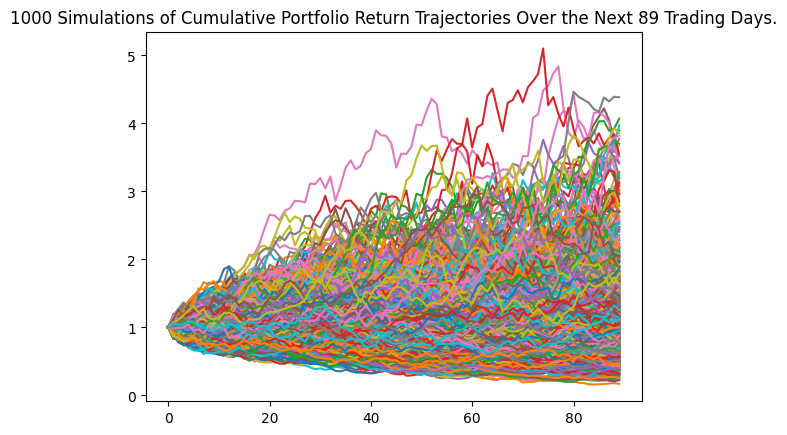

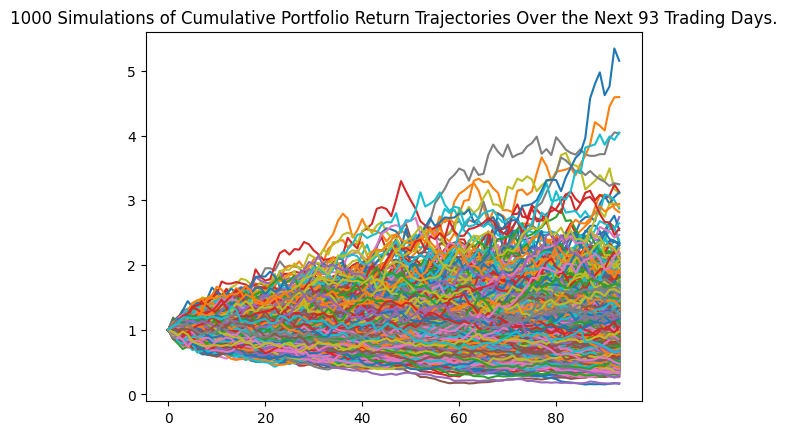

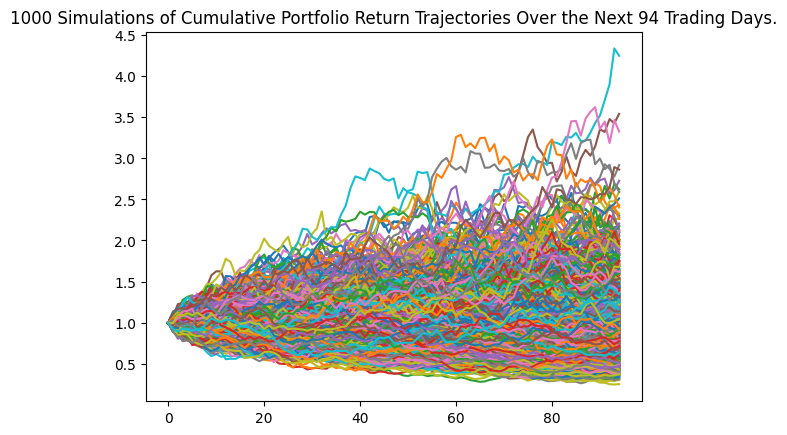

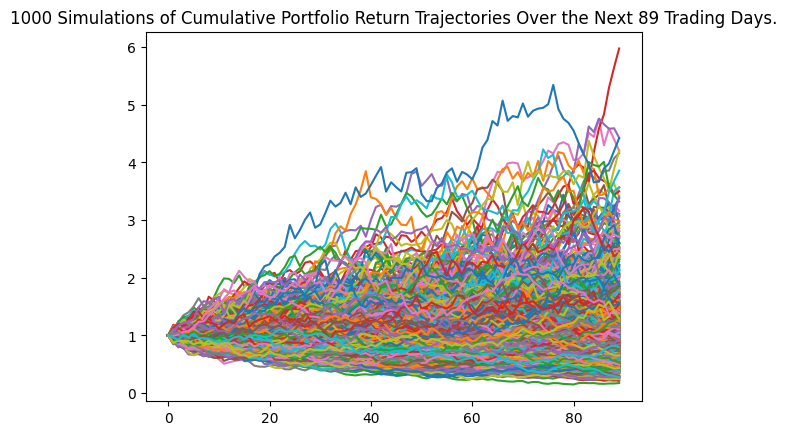

In [112]:
# plot simulations per season

winter.plot_simulation()
spring.plot_simulation()
summer.plot_simulation()
fall.plot_simulation()

<AxesSubplot: title={'center': 'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

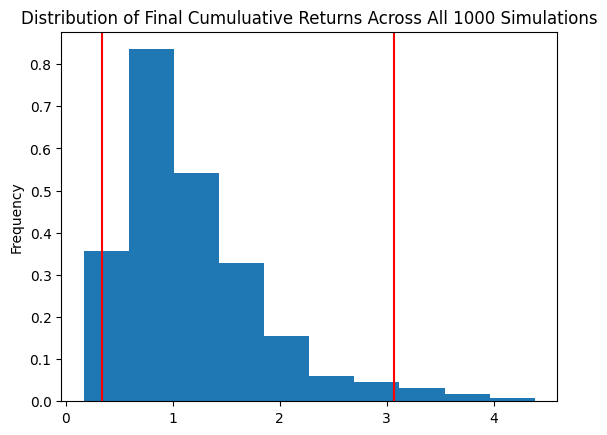

In [113]:
display(winter.plot_distribution())

<AxesSubplot: title={'center': 'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

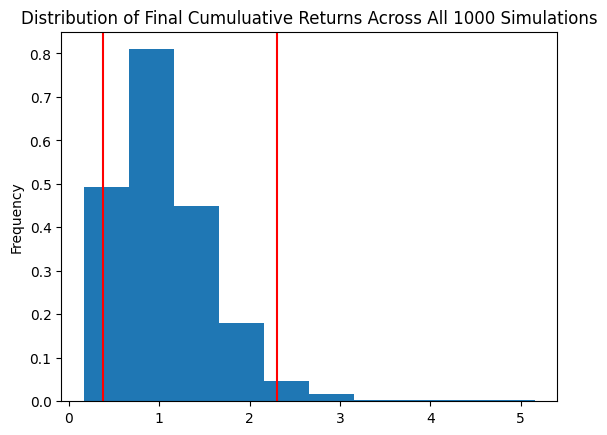

In [114]:
display(spring.plot_distribution())

<AxesSubplot: title={'center': 'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

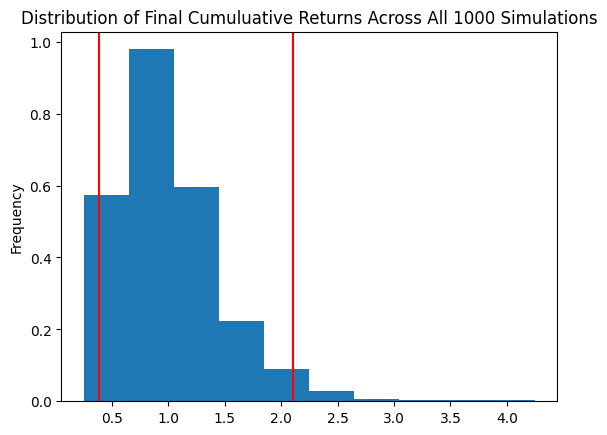

In [115]:
display(summer.plot_distribution())

<AxesSubplot: title={'center': 'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

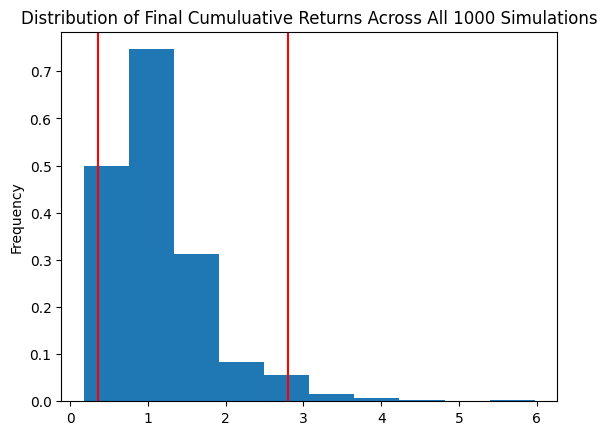

In [116]:
display(fall.plot_distribution())

In [117]:
#one_year_simulation.summarize_cumulative_return()

display(winter.summarize_cumulative_return())
display(spring.summarize_cumulative_return())
display(summer.summarize_cumulative_return())
display(fall.summarize_cumulative_return())

count           1000.000000
mean               1.175905
std                0.668995
min                0.169347
25%                0.701526
50%                1.010714
75%                1.466277
max                4.384695
95% CI Lower       0.337148
95% CI Upper       3.067060
Name: 89, dtype: float64

count           1000.000000
mean               1.050830
std                0.552125
min                0.164190
25%                0.670787
50%                0.907934
75%                1.320618
max                5.155228
95% CI Lower       0.374048
95% CI Upper       2.306678
Name: 93, dtype: float64

count           1000.000000
mean               1.001287
std                0.460442
min                0.252618
25%                0.667864
50%                0.918658
75%                1.216134
max                4.246573
95% CI Lower       0.386283
95% CI Upper       2.103203
Name: 94, dtype: float64

count           1000.000000
mean               1.138262
std                0.652301
min                0.174707
25%                0.708618
50%                0.981874
75%                1.384218
max                5.974516
95% CI Lower       0.357627
95% CI Upper       2.806531
Name: 89, dtype: float64